### DengAI: Predicting Disease Spread

https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/

Task is to predict the number of dengue cases each week (in each location) based on environmental variables describing changes in temperature, precipitation, vegetation, and more.

An understanding of the relationship between climate and dengue dynamics can improve research initiatives and resource allocation to help fight life-threatening pandemics.


In [1]:
import pandas as pd

import numpy as np
import math
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import random

from functools import partial

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import os
import json
import shap
from datetime import datetime

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

import joblib
import pickle
import json
import time
import gc
import logging
import missingno as msno
%matplotlib inline

pd.pandas.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("precision", 3)
pd.options.display.float_format = '{:,.2f}'.format

plt.style.use('fivethirtyeight')

begin = time.time() # Mark the start
gc.collect()

8

In [2]:
try:
    thread_count = os.cpu_count()

    # Note: os.cpu_count() on Python 3 relies on GetSystemInfo / NumberOfProcessors
    print("Number of CPUs in the system:", thread_count) 

    if thread_count:
        if thread_count > 1:
            thread_count = thread_count -1
    else:
        thread_count = -1
        
except:
    thread_count = -1
    
print("Thread Count to be used:", thread_count)

Number of CPUs in the system: 24
Thread Count to be used: 23


In [3]:
labels = pd.read_csv(r"dengue_labels_train.csv", low_memory=False)
feats = pd.read_csv(r"dengue_features_train.csv", low_memory=False)

df = pd.merge(feats, labels, on=['city', 'year', 'weekofyear'])

df['week_start_date'] = pd.to_datetime(df['week_start_date'], errors='coerce')
df.sort_values(by=['week_start_date'], inplace=True)
df.head(3)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.12,0.10,0.20,0.18,12.42,297.57,297.74,292.41,299.80,295.90,32.00,73.37,12.42,14.01,2.63,25.44,6.90,29.40,20.00,16.00,4
1,sj,1990,19,1990-05-07,0.17,0.14,0.16,0.16,22.82,298.21,298.44,293.95,300.90,296.40,17.94,77.37,22.82,15.37,2.37,26.71,6.37,31.70,22.20,8.60,5
2,sj,1990,20,1990-05-14,0.03,0.17,0.16,0.17,34.54,298.78,298.88,295.43,300.50,297.30,26.10,82.05,34.54,16.85,2.30,26.71,6.49,32.20,22.80,41.40,4


In [4]:
df.tail(3)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
1453,iq,2010,23,2010-06-11,0.25,0.15,0.25,0.23,58.94,296.60,297.59,295.50,305.50,292.40,50.60,94.28,58.94,17.01,7.50,24.40,6.90,32.20,19.20,7.40,1
1454,iq,2010,24,2010-06-18,0.33,0.25,0.28,0.33,59.67,296.35,297.52,295.32,306.10,291.90,62.33,94.66,59.67,16.82,7.87,25.43,8.73,31.20,21.00,16.00,1
1455,iq,2010,25,2010-06-25,0.30,0.23,0.27,0.32,63.22,298.10,299.84,295.81,307.80,292.30,36.90,89.08,63.22,17.36,11.01,27.48,9.90,33.70,22.20,20.40,4


In [5]:
df['city'].value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [6]:
df_test = pd.read_csv(r"dengue_features_test.csv", low_memory=False)
df_test['week_start_date'] = pd.to_datetime(df_test['week_start_date'], errors='coerce')
df_test.head(3)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.02,-0.02,0.10,0.09,78.60,298.49,298.55,294.53,301.10,296.40,25.37,78.78,78.60,15.92,3.13,26.53,7.06,33.30,21.70,75.20
1,sj,2008,19,2008-05-06,-0.02,-0.01,0.08,0.07,12.56,298.48,298.56,294.40,300.80,296.70,21.83,78.23,12.56,15.79,2.57,26.07,5.56,30.00,22.20,34.30
2,sj,2008,20,2008-05-13,-0.00,NaN,0.15,0.09,3.66,299.46,299.36,295.31,302.20,296.40,4.12,78.27,3.66,16.67,4.43,27.93,7.79,32.80,22.80,3.00


In [7]:
set(df.columns) - set(df_test.columns)

{'total_cases'}

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   city                                   1456 non-null   object        
 1   year                                   1456 non-null   int64         
 2   weekofyear                             1456 non-null   int64         
 3   week_start_date                        1456 non-null   datetime64[ns]
 4   ndvi_ne                                1262 non-null   float64       
 5   ndvi_nw                                1404 non-null   float64       
 6   ndvi_se                                1434 non-null   float64       
 7   ndvi_sw                                1434 non-null   float64       
 8   precipitation_amt_mm                   1443 non-null   float64       
 9   reanalysis_air_temp_k                  1446 non-null   float64 

In [9]:
df.isna().sum()

city                                       0
year                                       0
weekofyear                                 0
week_start_date                            0
ndvi_ne                                  194
ndvi_nw                                   52
ndvi_se                                   22
ndvi_sw                                   22
precipitation_amt_mm                      13
reanalysis_air_temp_k                     10
reanalysis_avg_temp_k                     10
reanalysis_dew_point_temp_k               10
reanalysis_max_air_temp_k                 10
reanalysis_min_air_temp_k                 10
reanalysis_precip_amt_kg_per_m2           10
reanalysis_relative_humidity_percent      10
reanalysis_sat_precip_amt_mm              13
reanalysis_specific_humidity_g_per_kg     10
reanalysis_tdtr_k                         10
station_avg_temp_c                        43
station_diur_temp_rng_c                   43
station_max_temp_c                        20
station_mi

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,"1,456.00","2,001.03",5.41,"1,990.00","1,997.00","2,002.00","2,005.00","2,010.00"
weekofyear,"1,456.00",26.50,15.02,1.00,13.75,26.50,39.25,53.00
ndvi_ne,"1,262.00",0.14,0.14,-0.41,0.04,0.13,0.25,0.51
ndvi_nw,"1,404.00",0.13,0.12,-0.46,0.05,0.12,0.22,0.45
ndvi_se,"1,434.00",0.20,0.07,-0.02,0.16,0.20,0.25,0.54
ndvi_sw,"1,434.00",0.20,0.08,-0.06,0.14,0.19,0.25,0.55
precipitation_amt_mm,"1,443.00",45.76,43.72,0.00,9.80,38.34,70.23,390.60
reanalysis_air_temp_k,"1,446.00",298.70,1.36,294.64,297.66,298.65,299.83,302.20
reanalysis_avg_temp_k,"1,446.00",299.23,1.26,294.89,298.26,299.29,300.21,302.93
reanalysis_dew_point_temp_k,"1,446.00",295.25,1.53,289.64,294.12,295.64,296.46,298.45


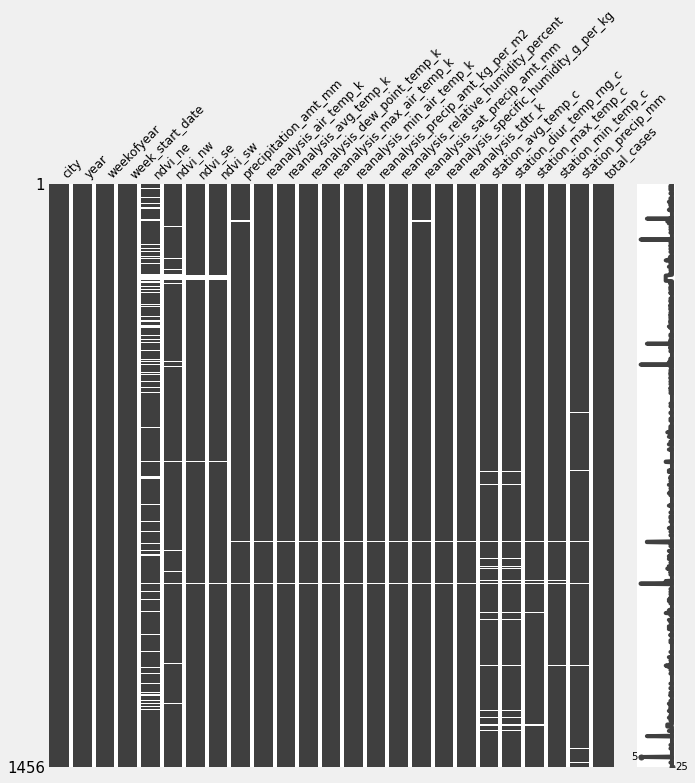

In [11]:
msno.matrix(df, figsize=(10, 10), fontsize=12);

- Station based features needs to be imputed properly as their presence/absence impact other metrics significantly.

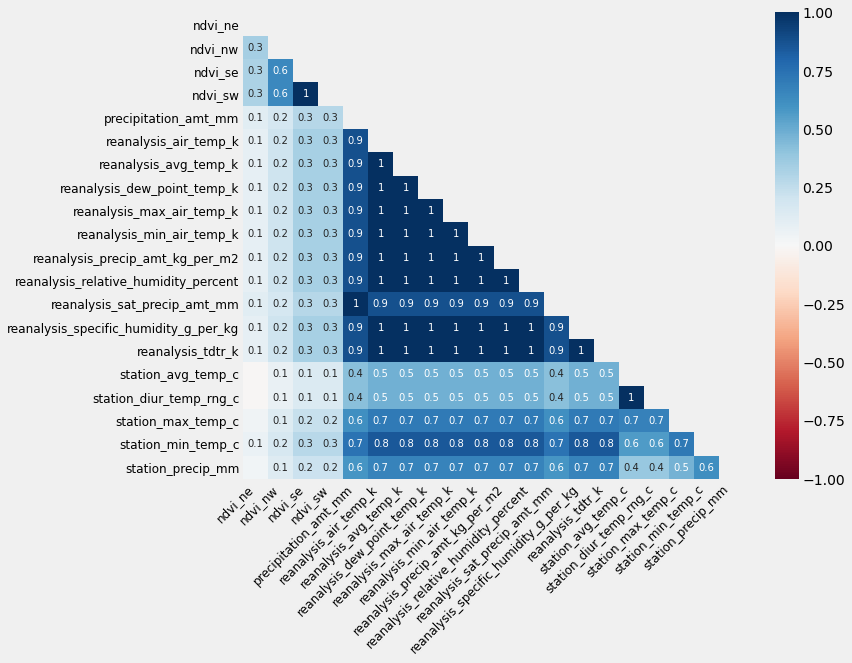

In [12]:
# How strongly the presence or absence of one variable affects the presence of another
msno.heatmap(df, figsize=(10, 8), fontsize=12);

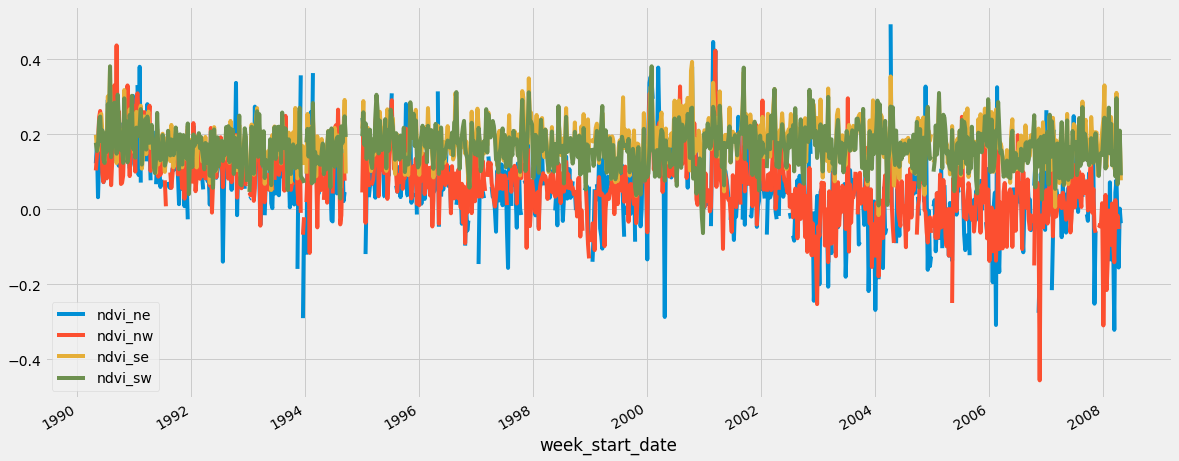

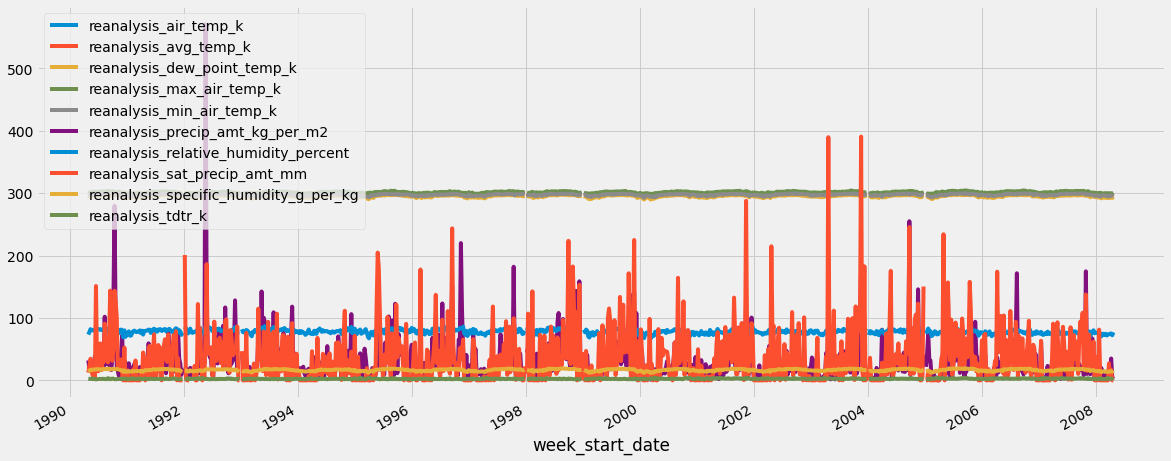

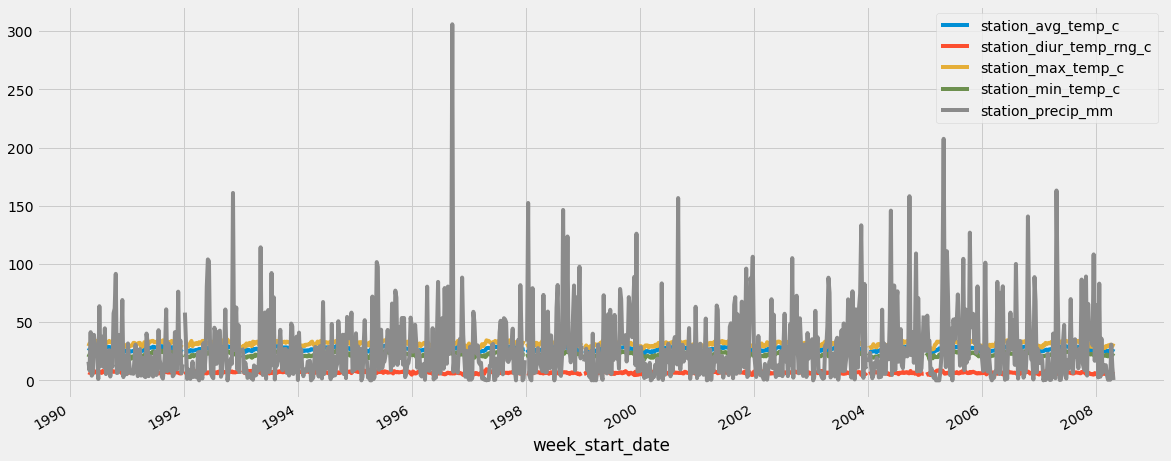

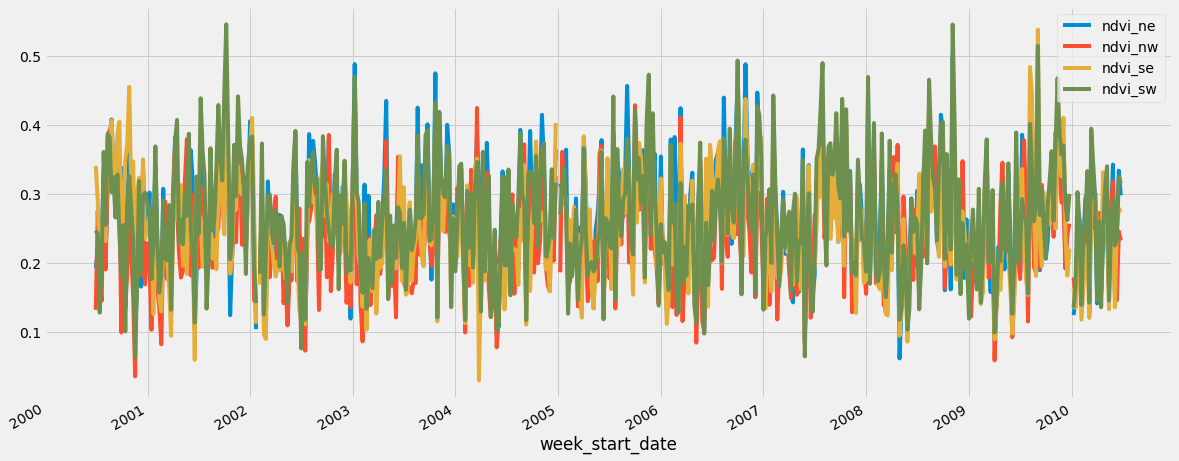

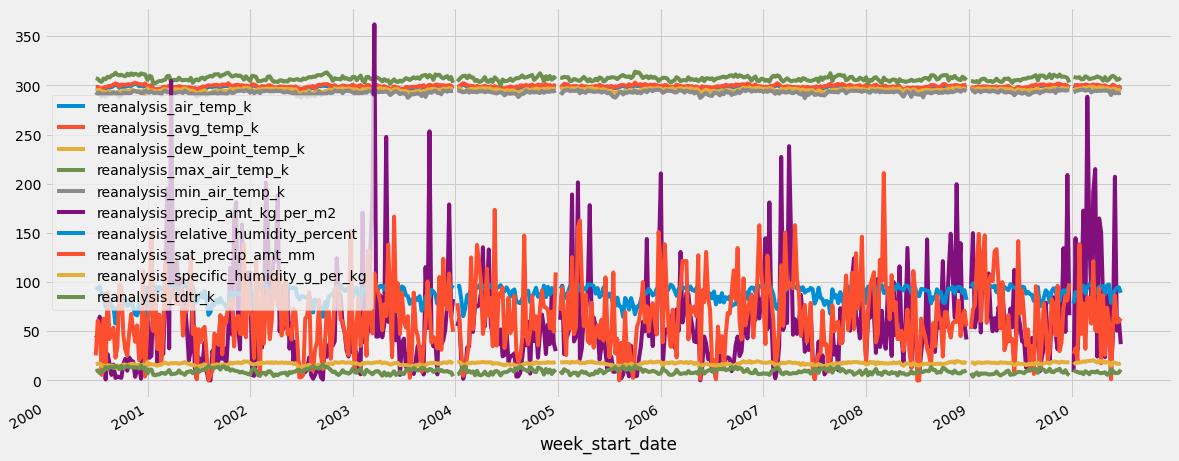

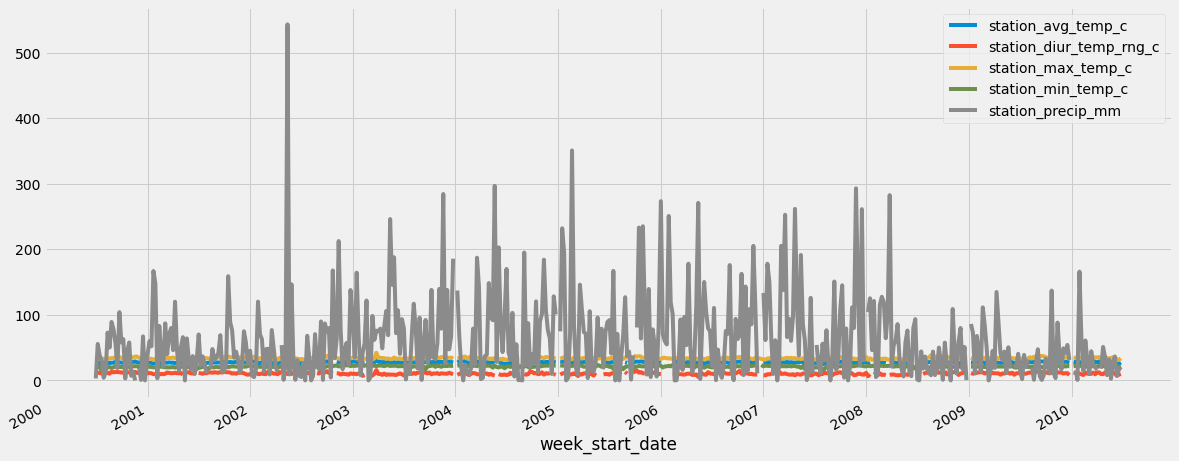

In [13]:
vals = ['ndvi', 'reanalysis', 'station']
cities = ['sj', 'iq']

# The plots below suggests seasonality for the parameters.

for city in cities:
    df_val = df[df['city'] == city].copy()
    df_val.index = df_val['week_start_date']
    for val in vals:
        filter_col = [col for col in df.columns if col.startswith(val)]
        df_val[filter_col].plot(figsize=(18,8));
        plt.show();
        
    print()

In [14]:
df[df['city'] == 'sj']['week_start_date'].min(), df[df['city'] == 'iq']['week_start_date'].min()

(Timestamp('1990-04-30 00:00:00'), Timestamp('2000-07-01 00:00:00'))

In [15]:
df[df['city'] == 'sj']['week_start_date'].max(), df[df['city'] == 'iq']['week_start_date'].max()

(Timestamp('2008-04-22 00:00:00'), Timestamp('2010-06-25 00:00:00'))

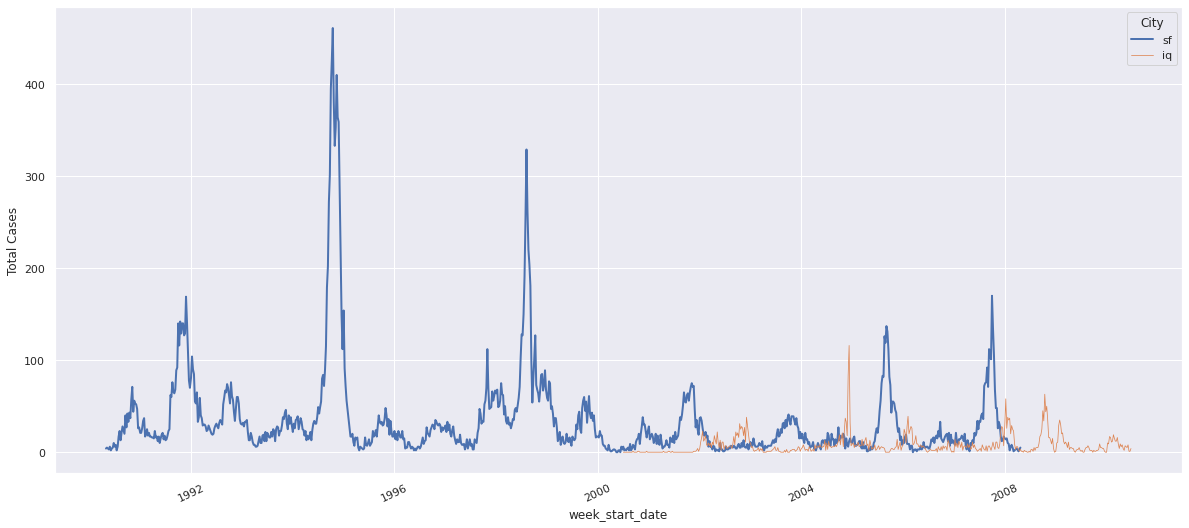

In [16]:
sns.set(rc={'figure.figsize':(18,8)})
sns.lineplot(x = "week_start_date", y = "total_cases", data = df[df['city'] == 'sj'], legend='brief', lw=2)
sns.lineplot(x = "week_start_date", y = "total_cases", data = df[df['city'] == 'iq'], size=6, lw=2)
plt.ylabel("Total Cases")
plt.xticks(rotation = 25);

plt.legend(labels=["sf","iq"], title = "City"); 

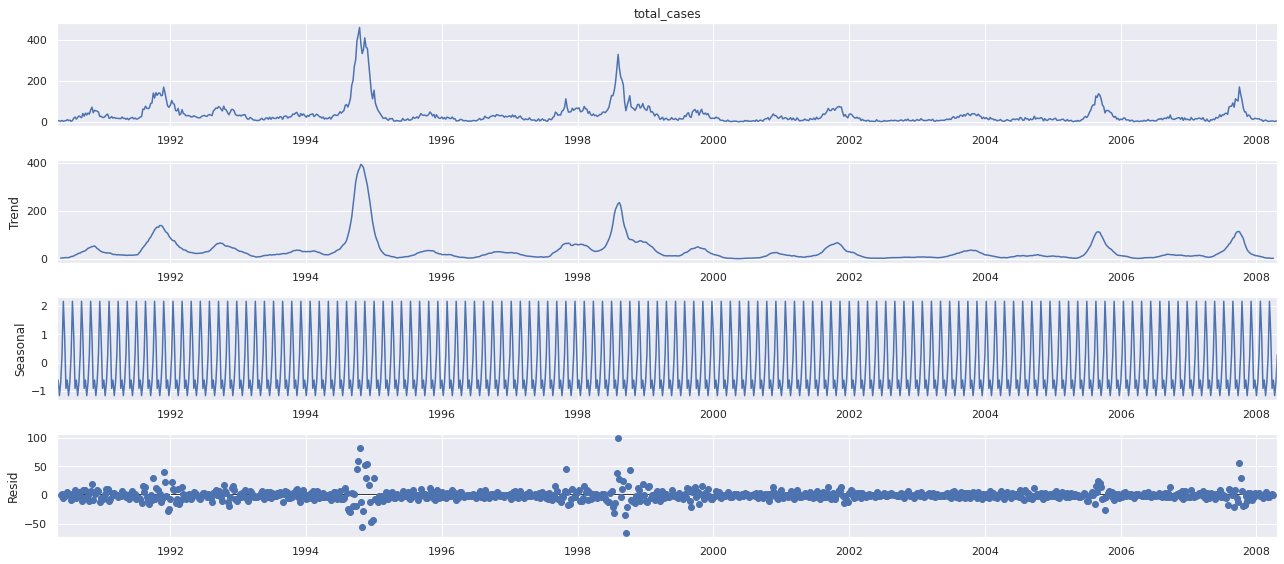

In [17]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

dfp = df[df['city'] == 'sj'].copy()
dfp['week_start_date'] = pd.to_datetime(dfp['week_start_date'], errors='coerce')
dfp.sort_values(by=['week_start_date'], inplace=True)
dfp.index = dfp['week_start_date']

decomposed = seasonal_decompose(dfp['total_cases'], model='additive', period=7)
decomposed.plot();

In [18]:
# 18 times weeks 1-51 occur ; 52nd week occurs 15 times wheres 53rd(leap) occurs only once.
df[df['city'] == 'sj'].groupby(['weekofyear']).size().value_counts()

18    51
15     1
3      1
dtype: int64

In [19]:
df[df['city'] == 'iq'].groupby(['weekofyear']).size().value_counts()

10    51
8      1
2      1
dtype: int64

In [20]:
city_cases = df.groupby(by=['city', 'weekofyear'])['total_cases'].sum().reset_index()
city_cases.columns = ['city', 'weekofyear', 'case_count']

In [21]:
city_cases.head(3)

,city,weekofyear,case_count
0,iq,1,93
1,iq,2,138
2,iq,3,108


In [22]:
city_cases.groupby(by='city')['case_count'].describe().T

city,iq,sj
count,53.00,53.00
mean,74.23,603.64
std,44.44,376.38
min,9.00,99.00
25%,35.00,251.00
50%,63.00,494.00
75%,108.00,990.00
max,203.00,"1,304.00"


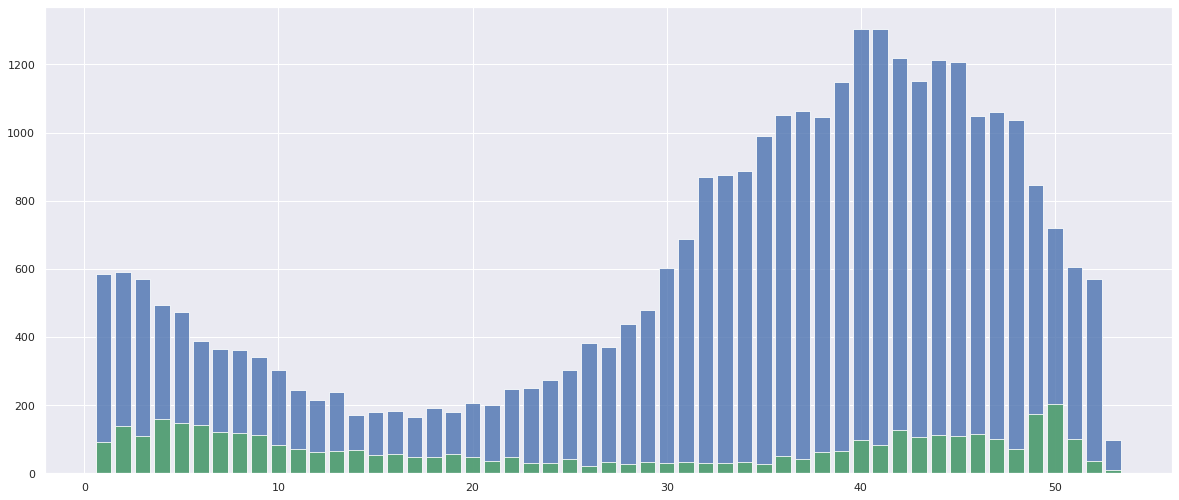

In [23]:
plt.bar(city_cases[city_cases['city'] == 'sj']['weekofyear'], city_cases[city_cases['city'] == 'sj']['case_count'], alpha=0.8, color='b');
plt.bar(city_cases[city_cases['city'] == 'iq']['weekofyear'], city_cases[city_cases['city'] == 'iq']['case_count'], alpha=0.8, color='g');

In [24]:
city_cases = df.groupby(by=['city', 'year', 'weekofyear'])['total_cases'].sum().reset_index()
city_cases.columns = ['city', 'year', 'weekofyear', 'total_cases']
city_cases.head(3)

,city,year,weekofyear,total_cases
0,iq,2000,26,0
1,iq,2000,27,0
2,iq,2000,28,0


#####  Over the years the number of cases have decreased considerably

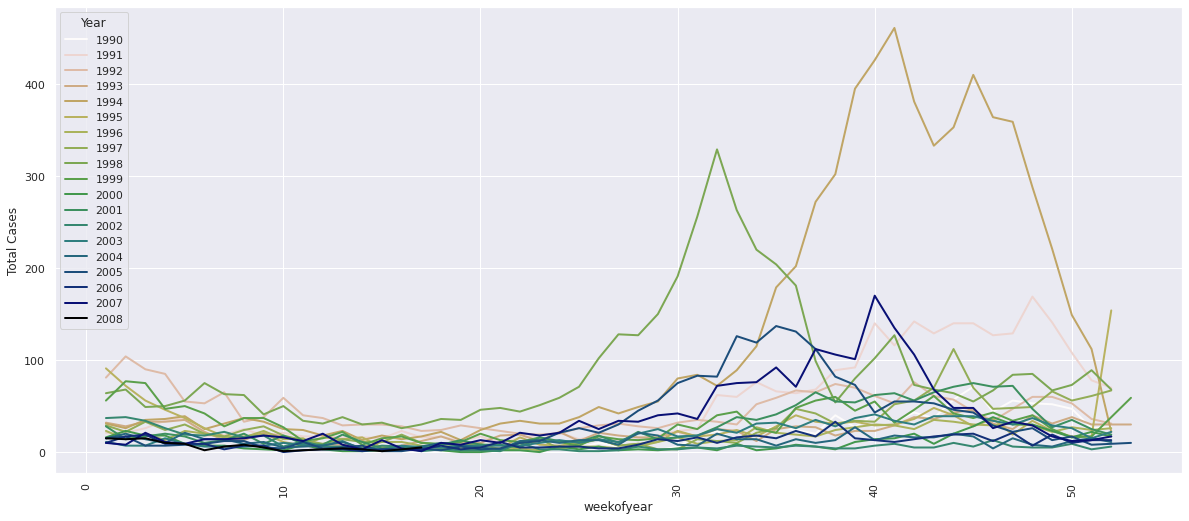

In [25]:
sns.set(rc={'figure.figsize':(18,8)})
sns.lineplot(x = "weekofyear", y = "total_cases", data = city_cases[city_cases['city'] == 'sj'], legend='brief', lw=2, hue='year', palette='gist_earth_r')
plt.ylabel("Total Cases")
plt.xticks(rotation = 90);
plt.legend(labels = city_cases[city_cases['city'] == 'sj']['year'].unique(), title = "Year"); 

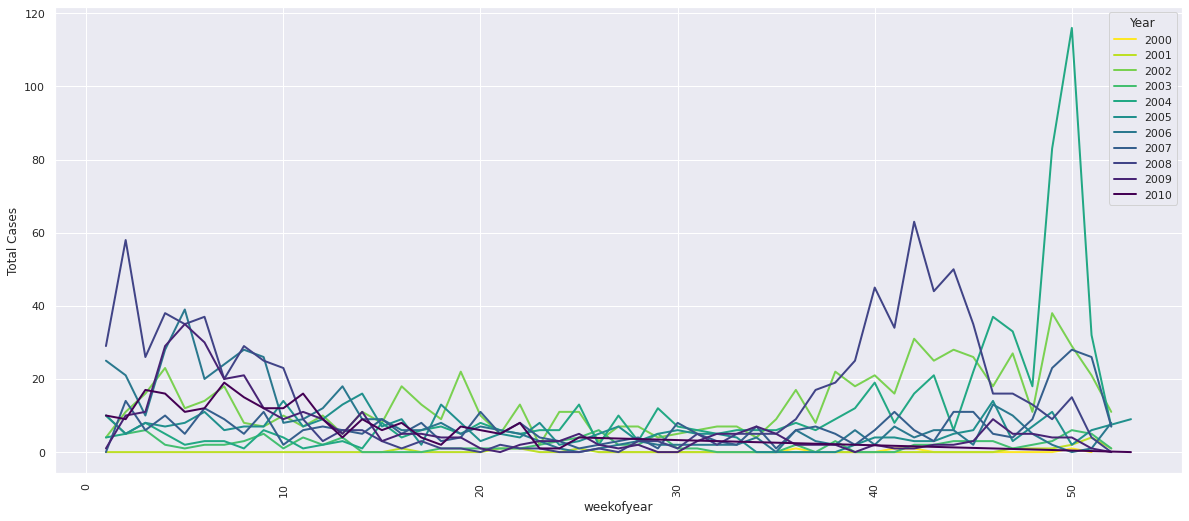

In [26]:
sns.set(rc={'figure.figsize':(18,8)})
sns.lineplot(x = "weekofyear", y = "total_cases", data = city_cases[city_cases['city'] == 'iq'], legend='brief', lw=2, hue='year', palette='viridis_r')
plt.ylabel("Total Cases")
plt.xticks(rotation = 90);
plt.legend(labels = city_cases[city_cases['city'] == 'iq']['year'].unique(), title = "Year"); 

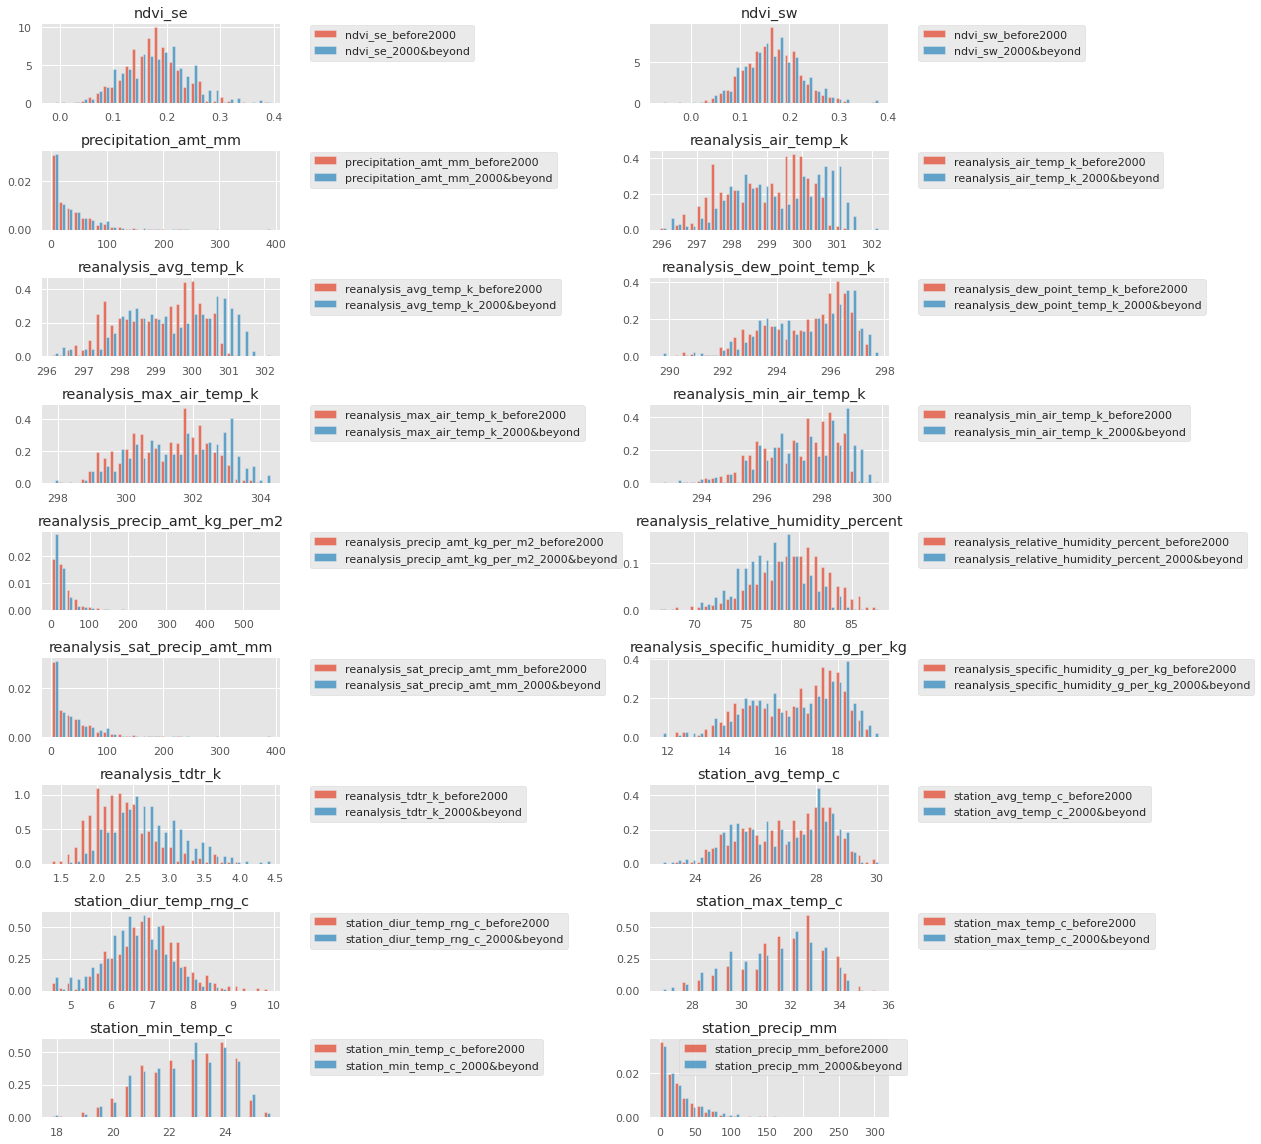

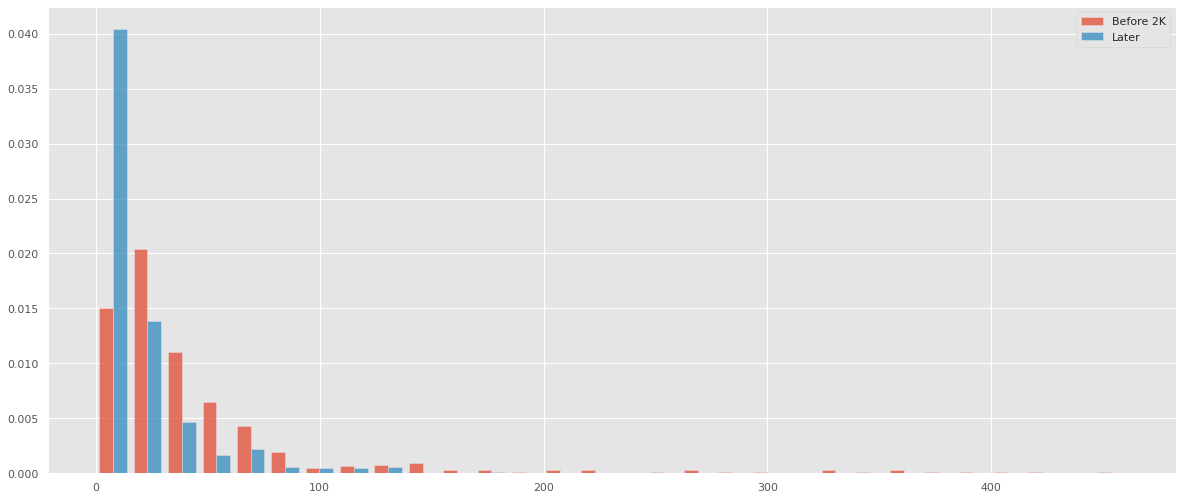

In [27]:
from scipy.stats import kurtosis, skew
        
def drift(df_x, df_y, bins=30, alpha=0.75):
        titles = ['ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 
                  'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
                   'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
                   'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
                   'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
                   'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
                   'station_min_temp_c', 'station_precip_mm']
        
        labels = [(item + "_before2000", item + "_2000&beyond") for item in titles]
        plt.style.use('ggplot')
        fig, ax = plt.subplots(9, 2, figsize=(18,16))
        ax = ax.ravel()
        for idx, ax in enumerate(ax):
            label_x, label_y = labels[idx]
            col_to_plot = titles[idx]
            ax.hist([df_x[col_to_plot], df_y[col_to_plot]], bins=bins, alpha=alpha, label=[label_x, label_y], density = True)
            ax.set_title(titles[idx])
            ax.legend();
            ax.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout();
        plt.show();
        print()
        
        plt.hist([df_x['total_cases'], df_y['total_cases']], bins=bins, alpha=alpha, label=['Before 2K', 'Later'], density = True);
        plt.legend();
        plt.show();

        
df_before2000sj = df[(df['city'] == 'sj') & (df['year'] < 2000)]
df_2000beyondsj = df[(df['city'] == 'sj') & (df['year'] >= 2000)]

drift(df_before2000sj, df_2000beyondsj, bins=30, alpha=0.75)

- Next Steps:
    - Make a base model.
    - Use month as feature.
    - Use that to understand important features.
    - Impute missing values based on that understanding.
    - Define appropriate loss function. 